Compare the regression slopes of low-cloud fraction as a function of distance from the sea ice edge (χ) for multiple climate models and observations. The analysis quantifies how cloud fraction changes across the sea ice–ocean transition zone during northern hemisphere winter and summer seasons.

In [9]:
import os
import xarray as xr
import numpy as np
import pandas as pd
from scipy.stats import linregress, t
import matplotlib.pyplot as plt

In [10]:
def calculate_slope_and_error(x, y):
    x_range_model = np.logical_and(x >= -6.5, x <= 6.5)
    x_filtered = x[x_range_model]
    y_filtered = y[x_range_model]

    x_range_regression = np.logical_and(x_filtered >= -2.5, x_filtered <= 2.5)
    x_regression = x_filtered[x_range_regression]
    y_regression = y_filtered[x_range_regression]

    slope, intercept, r_value, p_value, std_err = linregress(x_regression, y_regression)
    return slope, std_err

# === Define directories ===
cmip_directory = '/home/rcostell/Model_Files/CMIP6/Historical/Paper_Files/Binned_2D_Meteorology/'
amip_directory = '/home/rcostell/Model_Files/CMIP6/AMIP/Paper_Files/Binned_2D_Meteorology/'
obs_file = '/home/rcostell/Observation_Files/Paper_Files/Meteorology/CALIPSO_Binned_2D_CF.nc'

# === Define seasons (only winter and summer) ===
seasons = {'winter': 0, 'summer': 1}

def extract_model_name(filepath):
    """Extract the model name from CMIP or AMIP filenames."""
    base = os.path.basename(filepath)
    if '_AMIP_' in base:
        model = base.split('_AMIP_')[0]
    else:
        model = base.split('_Binned_')[0]
    return model

In [11]:
# === Get CMIP files ===
cmip_files = sorted([
    os.path.join(cmip_directory, f)
    for f in os.listdir(cmip_directory)
    if f.endswith('_Binned_2D_Meteorology.nc') and '_AMIP_' not in f
])

# === Get AMIP files ===
amip_files = sorted([
    os.path.join(amip_directory, f)
    for f in os.listdir(amip_directory)
    if f.endswith('_Binned_2D_Meteorology.nc') and '_AMIP_' in f
])

# === Extract model names ===
cmip_models = [extract_model_name(f) for f in cmip_files]
amip_models = [extract_model_name(f) for f in amip_files]

# === Merge model lists ===
all_models = sorted(set(cmip_models).union(amip_models))
common_models = sorted(set(cmip_models).intersection(amip_models))

print(f"\nModels with *both* CMIP and AMIP data ({len(common_models)}):")
print(common_models)
print(f"\nTotal models available (including CMIP-only): {len(all_models)}")
print(all_models)

# === Store file mapping for later ===
model_files = {}
for model in all_models:
    cmip_match = [f for f in cmip_files if model in f]
    amip_match = [f for f in amip_files if model in f]
    model_files[model] = {
        "cmip": cmip_match[0] if cmip_match else None,
        "amip": amip_match[0] if amip_match else None
    }


Models with *both* CMIP and AMIP data (9):
['CCCma', 'CNRM', 'E3SM', 'E3SMHiRes', 'GFDL', 'IPSL6', 'MIROC', 'MRI', 'NCAR']

Total models available (including CMIP-only): 12
['CCCma', 'CNRM', 'E3SM', 'E3SMHiRes', 'E3SM_1_1', 'E3SM_1_1_ECA', 'GFDL', 'IPSL5', 'IPSL6', 'MIROC', 'MRI', 'NCAR']


CMIP Avg Slopes: {'winter': np.float64(1.7602133060089502), 'summer': np.float64(-0.913481104766458)}
AMIP Avg Slopes: {'winter': np.float64(1.000211466974902), 'summer': np.float64(-1.2491248742689944)}


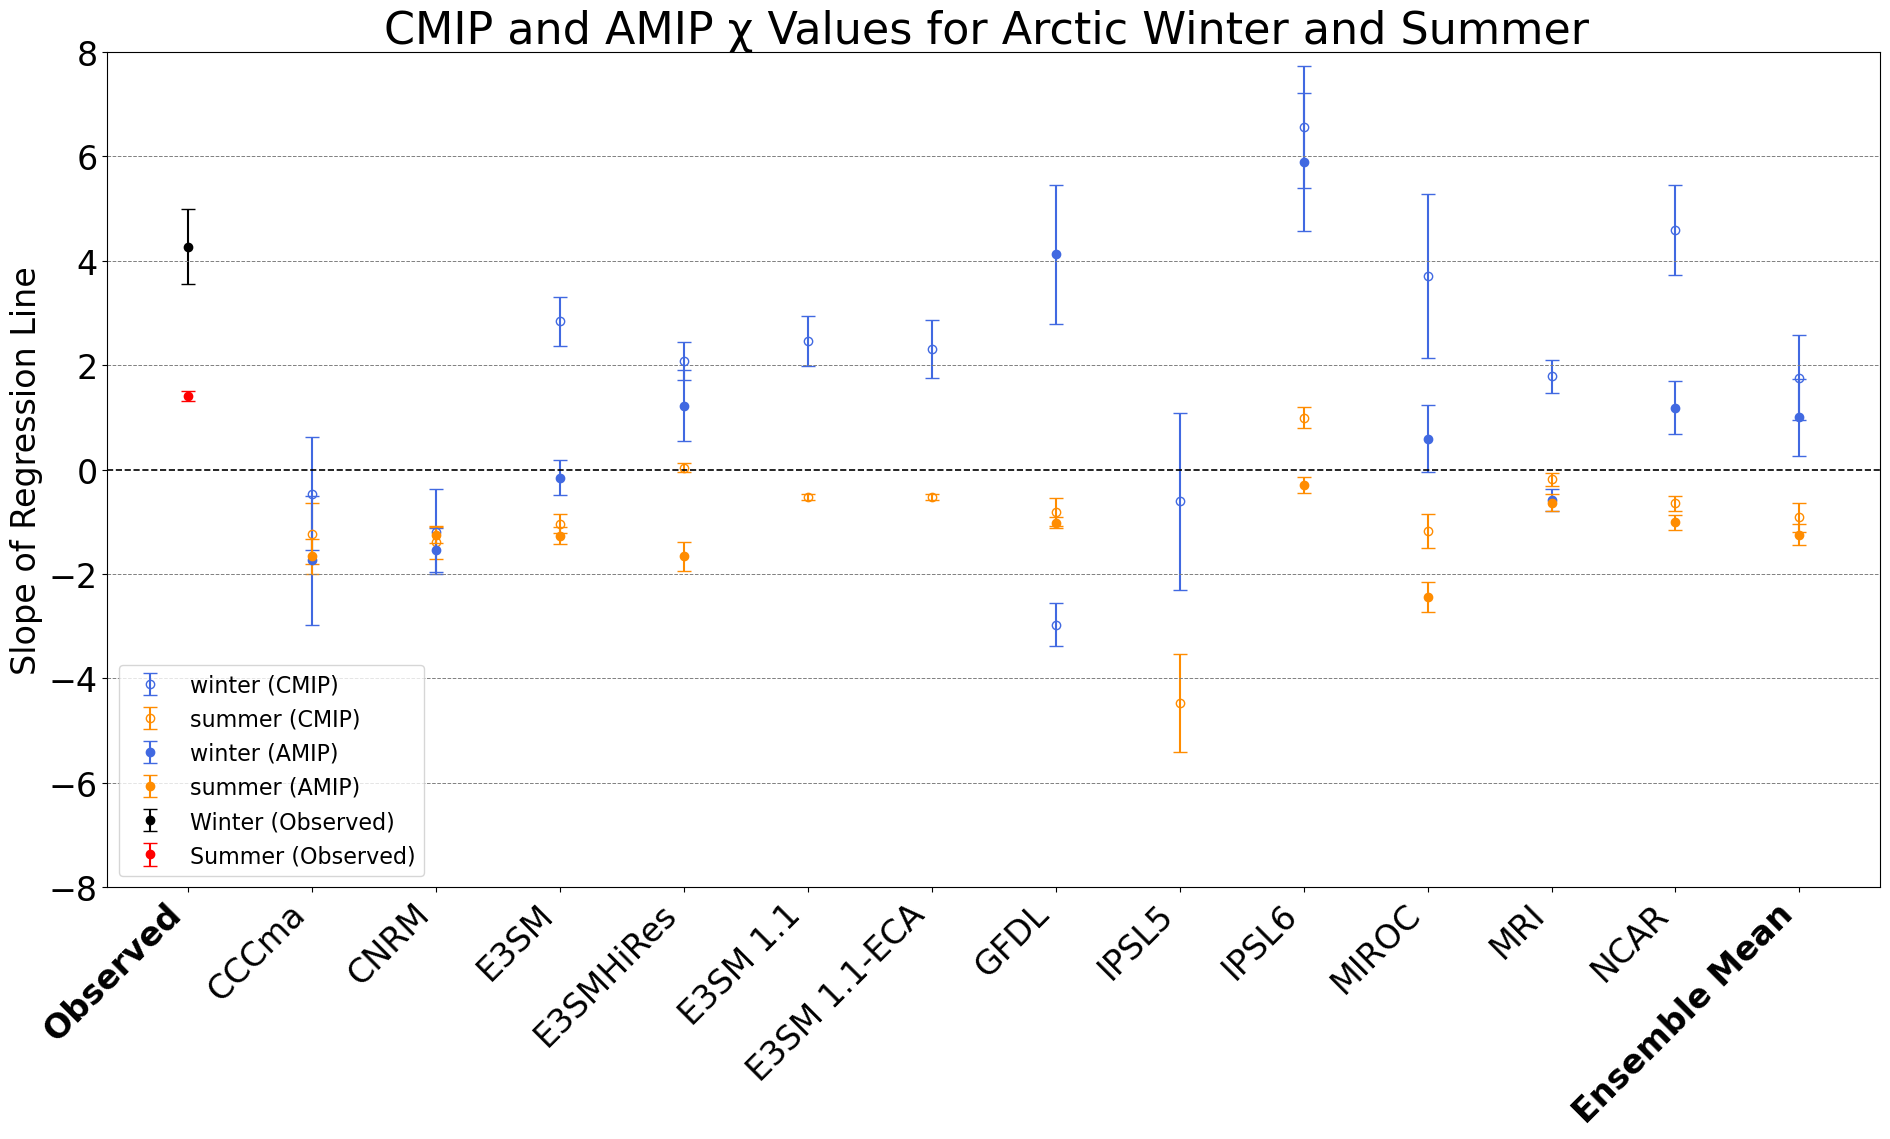

In [12]:
# === Initialize dictionaries for slopes/errors ===
all_models = sorted(set(
    [extract_model_name(f) for f in cmip_files] + 
    [extract_model_name(f) for f in amip_files]
))

model_slopes = {m: {s: None for s in seasons.keys()} for m in all_models}
model_errors = {m: {s: None for s in seasons.keys()} for m in all_models}
amip_slopes = {m: {s: None for s in seasons.keys()} for m in all_models}
amip_errors = {m: {s: None for s in seasons.keys()} for m in all_models}

# === Load observational data ===
obs = xr.open_dataset(obs_file).groupby("time.season").mean()

# === Process CMIP model data ===
for model_file in cmip_files:
    model_name = extract_model_name(model_file)
    model_data = xr.open_dataset(os.path.join(cmip_directory, model_file))
    model_data = model_data.groupby("time.season").mean()

    model_x = -model_data.distance.values  # Always negate for plotting from ice edge

    for season_name, season_index in seasons.items():
        model_y = model_data.cllcalipso.isel(season=season_index).values
        slope, std_err = calculate_slope_and_error(model_x, model_y)
        model_slopes[model_name][season_name] = slope
        model_errors[model_name][season_name] = std_err

# === Process AMIP model data ===
for model_file in amip_files:
    model_name = extract_model_name(model_file)
    model_data = xr.open_dataset(os.path.join(amip_directory, model_file))
    model_data = model_data.groupby("time.season").mean()

    model_x = -model_data.distance.values

    for season_name, season_index in seasons.items():
        model_y = model_data.cllcalipso.isel(season=season_index).values
        slope, std_err = calculate_slope_and_error(model_x, model_y)
        amip_slopes[model_name][season_name] = slope
        amip_errors[model_name][season_name] = std_err

# === Average across all CMIP models ===
cmip_avg_slopes = {}
cmip_avg_errors = {}

for season_name in seasons.keys():
    slopes = [model_slopes[m][season_name] for m in model_slopes if model_slopes[m][season_name] is not None]
    errors = [model_errors[m][season_name] for m in model_errors if model_errors[m][season_name] is not None]
    
    cmip_avg_slopes[season_name] = np.mean(slopes) if slopes else None
    cmip_avg_errors[season_name] = np.mean(errors) if errors else None

# === Average across all AMIP models ===
amip_avg_slopes = {}
amip_avg_errors = {}

for season_name in seasons.keys():
    slopes = [amip_slopes[m][season_name] for m in amip_slopes if amip_slopes[m][season_name] is not None]
    errors = [amip_errors[m][season_name] for m in amip_errors if amip_errors[m][season_name] is not None]
    
    amip_avg_slopes[season_name] = np.mean(slopes) if slopes else None
    amip_avg_errors[season_name] = np.mean(errors) if errors else None

obs_f = xr.open_dataset(obs_file).groupby("time.season").mean()

obs_x = -obs_f.distance.values

obs_slopes = {season: None for season in seasons.keys()}
obs_errors = {season: None for season in seasons.keys()}

for season_name, season_index in seasons.items():
    obs_y = obs_f.cllcalipso.isel(season=season_index).values * 100 # Do not convert to percentages
    slope, std_err = calculate_slope_and_error(obs_x, obs_y)
    obs_slopes[season_name] = slope
    obs_errors[season_name] = std_err

# Combine observed slopes with model slopes
model_slopes['Observed'] = obs_slopes
model_errors['Observed'] = obs_errors

print("CMIP Avg Slopes:", cmip_avg_slopes)
print("AMIP Avg Slopes:", amip_avg_slopes)

fig, ax = plt.subplots(figsize=(19, 11.5))

# Define new seasonal colors
season_colors = {'winter': 'royalblue', 'summer': 'darkorange'}

model_names_no_obs = [m for m in model_slopes.keys() if m != "Observed"]
model_names_extended = ["Observed"] + model_names_no_obs + ["Ensemble Mean"]
x_pos = np.arange(len(model_names_extended))
observed_index = 0
avg_index = len(model_names_extended) - 1

# Plot CMIP models
for model_index, model_name in enumerate(model_names_no_obs):
    slopes = model_slopes.get(model_name, {})
    errors = model_errors.get(model_name, {})
    for season_name in ['winter', 'summer']:
        slope = slopes.get(season_name)
        std_err = errors.get(season_name)
        if slope is not None:
            # Shift index by +1 to leave first column for Observed
            ax.errorbar(
                model_index + 1, slope, yerr=std_err, fmt='o', 
                color=season_colors[season_name], markerfacecolor='none',
                capsize=5, label=f'{season_name} (CMIP)' if model_index == 0 else ""
            )

amip_marker = 'o'
for model_name in amip_models:
    if model_name == 'Observed':
        continue
    if model_name in amip_slopes:
        slopes = amip_slopes[model_name]
        errors = amip_errors[model_name]
        for season_name in ['winter', 'summer']:
            slope = slopes.get(season_name)
            std_err = errors.get(season_name)
            if slope is not None:
                x_pos_index = model_names_no_obs.index(model_name) + 1
                ax.errorbar(
                    x_pos_index, slope, yerr=std_err, fmt=amip_marker, 
                    color=season_colors[season_name], capsize=5, 
                    label=f'{season_name} (AMIP)'
                )
                
# Plot CMIP averages (no label)
for season_name in ['winter', 'summer']:
    slope = cmip_avg_slopes.get(season_name)
    std_err = cmip_avg_errors.get(season_name)
    if slope is not None:
        ax.errorbar(
            avg_index, slope, yerr=std_err, fmt='o',  # use same circle markers
            markerfacecolor='none',                   # keep CMIP style (hollow)
            color=season_colors[season_name], capsize=5
        )

# Plot AMIP averages (no label)
for season_name in ['winter', 'summer']:
    slope = amip_avg_slopes.get(season_name)
    std_err = amip_avg_errors.get(season_name)
    if slope is not None:
        ax.errorbar(
            avg_index, slope, yerr=std_err, fmt='o',  # use same circle markers
            markerfacecolor=season_colors[season_name],  # filled for AMIP
            color=season_colors[season_name], capsize=5
        )

observed_index = 0
for season_name, season_index in seasons.items():
    slope = obs_slopes.get(season_name)
    std_err = obs_errors.get(season_name)
    obs_color = 'black' if season_name == 'winter' else 'red'
    if slope is not None:
        ax.errorbar(
            observed_index, slope, yerr=std_err, fmt='o',
            color=obs_color, capsize=5,
            label=f'{season_name.capitalize()} (Observed)'
        )

# Add a dashed gray line at y = 0
ax.axhline(-6, color='gray', linestyle='--', linewidth=0.7)
ax.axhline(-4, color='gray', linestyle='--', linewidth=0.7)
ax.axhline(-2, color='gray', linestyle='--', linewidth=0.7)
ax.axhline(0, color='black', linestyle='--', linewidth=1.2)
ax.axhline(2, color='gray', linestyle='--', linewidth=0.7)
ax.axhline(4, color='gray', linestyle='--', linewidth=0.7)
ax.axhline(6, color='gray', linestyle='--', linewidth=0.7)

# Set plot labels and title
rename_map = {
    "E3SM_1_1": "E3SM 1.1",
    "E3SM_1_1_ECA": "E3SM 1.1-ECA"
}

# Replace underscores globally, then apply mapping for specific cases
pretty_model_names = [
    rename_map.get(name, name.replace("_", " ")) for name in model_names_extended
]

# Set plot labels and title
ax.set_xticks(x_pos)
ax.set_xticklabels(pretty_model_names, rotation=45, ha='right', fontsize=24)
for label in ax.get_xticklabels():
    if label.get_text() in ["Observed", "Ensemble Mean"]:
        label.set_fontweight("bold")

#ax.set_xlabel('Model', fontsize=24)
ax.set_ylabel('Slope of Regression Line', fontsize=24)
ax.tick_params(axis='y', labelsize=24)
ax.set_title(f"CMIP and AMIP χ Values for Arctic Winter and Summer ", fontsize=32)

# Set the y-axis limits
ax.set_ylim(-8, 8)

# Create a legend
handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys(), loc='best', fontsize = 16)

# Save and display the plot
#plt.savefig(f"/home/rcostell/Projects/CMIP6_Intercomparison/Figures/CMIP_AMIP_Slopes.png", bbox_inches="tight", dpi=1000)
plt.tight_layout()
plt.show()